<a href="https://colab.research.google.com/github/liapunov/HRdata/blob/master/HRdataNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

## Problem definition and context
The purpose of this small project is to apply simple data transformations and machine learning techniques in order to predict the expected salary of people person given a few descriptors such as their job title, their education and their experience.

While the dataset examined here is a heavily simplified data model of a real-world job market, the procedures implemented here should be easily transferable to more complex scenarios and with a richer variety of categories.

## The Data

The data we will work on in this project are:
- 1,000,000 training examples, complete with salary information
- 1,000,000 test examples, with no salary information attached

As we will see when looking at the properties of each feature, at a first look the data seem to have been machine-generated over a uniform distribution. We will expect a lot of noise barring us from predicting the target with very high accuracy. Nevertheless, the data do show some interesting pattern that will eventually drive our hypotheses in building an appropriate model.

Let's start by loading and having a first glance at the data.

In [2]:
# Libraries we are going to use for EDA
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from supervisedf import SupervisedDataframe

from scipy.stats import norm, beta, normaltest, kruskal
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgbm

import tensorflow as tf
from keras.models import Sequential
from keras.activations import relu
from keras.layers import Dense, Dropout, BatchNormalization

# We will save and access the data on Google Drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive

#gauth = GoogleAuth()
#gauth.LocalWebserverAuth()

#drive = GoogleDrive(gauth)

__author__ = "Francesco Rinarelli"
__email__ = "f.rinarelli@gmail.com"


# If you can access the Internet decomment below:
# file_base = "https://drive.google.com/drive/folders/1AXcVmd0LHrrwuVEptda5xmlFRaOvDgm8/"
# (it's a public access folder, so you can download the dataset if you want)
# If you are working on google colab and need to access your drive repository decomment below:
file_base = "data/"

In [3]:
def short_track(train_src, test_src, target_src = ""):
    job_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5,\
           "CTO":5, "CEO": 6}
    degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}
    num_to_scale = ["yearsExperience","milesFromMetropolis","groupMean","groupMedian",\
                    "groupVar", "jobType", "degree"]
    categories = ["major","industry"]
    
    print("Creating new Supervised Dataframe instance...")
    hr_data = SupervisedDataframe(train_src, test_src, target_src)
    print("Erasing non-positive salaries...")
    hr_data.merged.loc["train"] = hr_data.merged[hr_data.merged["salary"] > 0]
    print("Erasing useless features companyId and JobId...")
    hr_data.merged = hr_data.merged.drop(columns=["companyId","jobId"])
    print("Creating group statistics out of categories...")
    hr_data.create_grouped_stats(["jobType","major","degree","industry"])
    print("Transforming jobType and degree into ordinals...")
    hr_data.dict_replace("jobType",job_dict)
    hr_data.dict_replace("degree",degree_dict)
    print("Scaling the numerical features...")
    hr_data.scale(num_to_scale, method="standard")
    print("Binarizing the categorical features...")
    hr_data.to_one_hot(categories)
    print("Return features, target and test features...")
    feat_train, target_train = hr_data.split_feature_target()
    feat_test = hr_data.get_test()
    print("Done!")
    return feat_train, target_train, feat_test

In [4]:
hr_data = SupervisedDataframe("train_features.csv","test_features.csv","train_salaries.csv")

created dataframes with implied target column "salary"
Implied categorical variables: ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
Implied numerical variables: ['yearsExperience', 'milesFromMetropolis', 'salary']
Implied datetime variables: []
information about the train DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   jobId                1000000 non-null  object 
 1   companyId            1000000 non-null  object 
 2   jobType              1000000 non-null  object 
 3   degree               1000000 non-null  object 
 4   major                1000000 non-null  object 
 5   industry             1000000 non-null  object 
 6   yearsExperience      1000000 non-null  int64  
 7   milesFromMetropolis  1000000 non-null  int64  
 8   salary               1000000 non-null  float64
dtypes: float6

As we can see, the features table has eight columns. The first column, jobId, seems to be a key value. We will check that there are no duplicate items in it.

In [6]:
# check for duplicate jobId's
assert hr_data.merged.jobId.nunique() == hr_data.merged.jobId.count()

*companyId*, *jobType*, *degree*, *major* and *industry* are all categorical features, and they all seem quite self-explanatory. Other two columns, *yearsExperience* and *milesFromMetropolis* are continuous values.

We should perform a few sanity checks on the columns, to see whether there are NA values, or values that are out of the expected range - e.g. negative YearsExperience or milesFrom Metropolis.

In [7]:
# Are there blank values for any of the columns?
hr_data.check_nulls()

there are no NA values in the training dataFrame.


False

In [8]:
# Check for negative values on continuous features
# is a 0 mile distance possible? I think so.
print("negative miles from city?")
hr_data.merged[hr_data.merged["milesFromMetropolis"]<0]
print("negative years of experience?")
hr_data.merged[hr_data.merged["yearsExperience"]<0]
print("non positive salaries?")
hr_data.merged[hr_data.merged["salary"]<=0]

negative miles from city?
negative years of experience?
non positive salaries?


jobId companyId         jobType       degree  \
train 30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL   
      495984  JOB1362684903671    COMP34          JUNIOR         NONE   
      652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL   
      816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL   
      828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS   

                    major industry  yearsExperience  milesFromMetropolis  \
train 30559          MATH     AUTO               11                    7   
      495984         NONE      OIL                1                   25   
      652076         NONE     AUTO                6                   60   
      816129  ENGINEERING  FINANCE               18                    6   
      828156  ENGINEERING      WEB                3                   29   

              salary  
train 30559      0.0  
      495984     0.0  
      652076     0.0  
      816129     0.0  
      828156     0.0

It seems that there are no macroscopical errors in the data. We did find five rows with salary equal to zero. In a broader study, one could archive these data points as possible volunteering activity, but they look suspicious here. Let' get rid of these jobId both from salary and from the features.

In [9]:
# Since it is the target variable, we need to limit the edit to the train only.
# Would really need a specific method to manage this case.
hr_data.merged.loc["train"] = hr_data.merged[hr_data.merged["salary"] > 0]

print(hr_data.merged[hr_data.merged.salary <= 0].values)

[]


Let's now try to explore more in detail the features. Since there are not so many, a direct approach for each of them will work finely.

In [10]:
# How many unique values for each categorial feature?
hr_data.merged[hr_data.categoricals].nunique()

jobId        1999995
companyId         63
jobType            8
degree             5
major              9
industry           7
dtype: int64

There are 63 companies involved, 8 different job titles, 5 levels of education, 9 majors (including the "none" major for employees with no college degree), and 7 industries.

Of course, there must have been an intense work of simplification, as we are only dealing with 7 possible job types, but let's assume this does not affect significantly the expressivity of the data.

We might of course ask whether companies have all the same number of employees. This is an easy check.

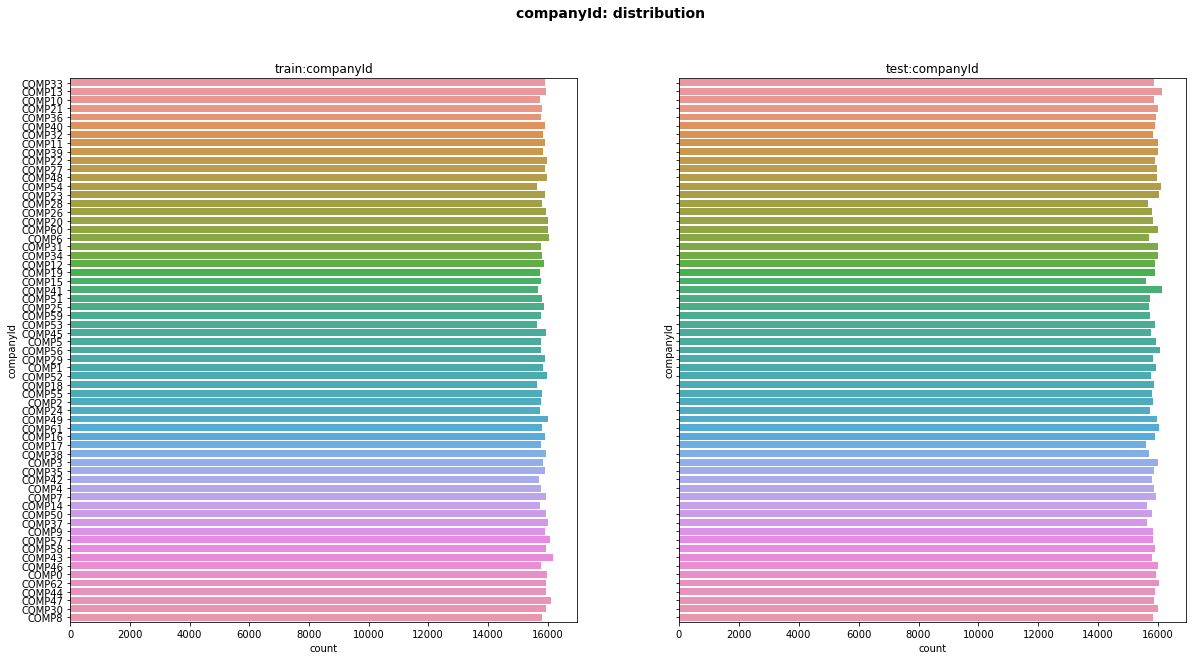

In [11]:
hr_data.plot_variable("companyId")

It seems that all 63 companies have more or less the same number of employees, which is strange! At least, we can say that company size is probably not going to affect predictions much.

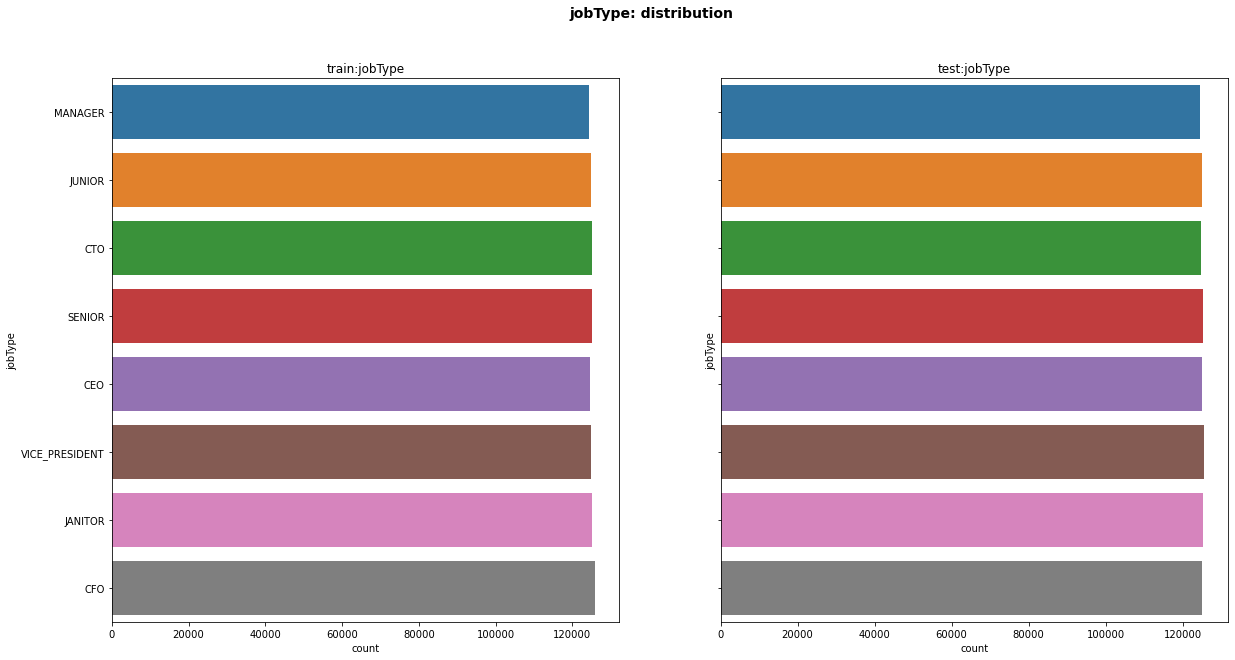

In [12]:
hr_data.plot_variable("jobType")

The job titles are also, curiosly, evenly distributed. Indeed, we can verify the same with industry, yearsExperience and milesFromMetropolis.

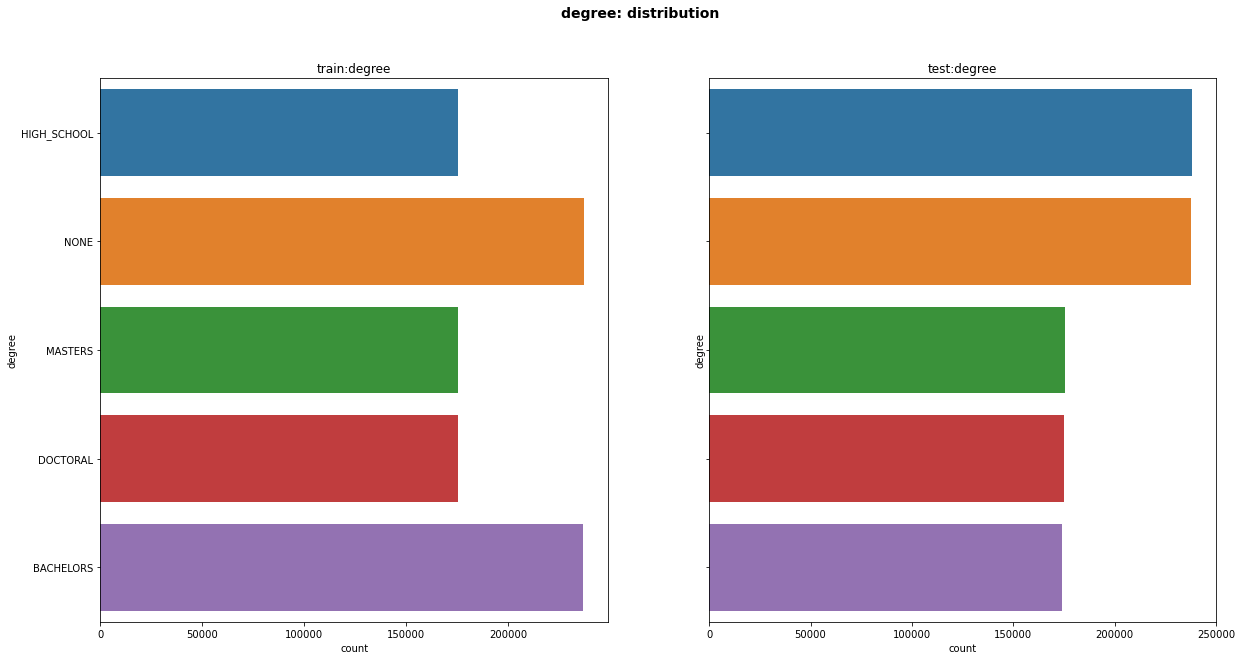

In [13]:
hr_data.plot_variable("degree")

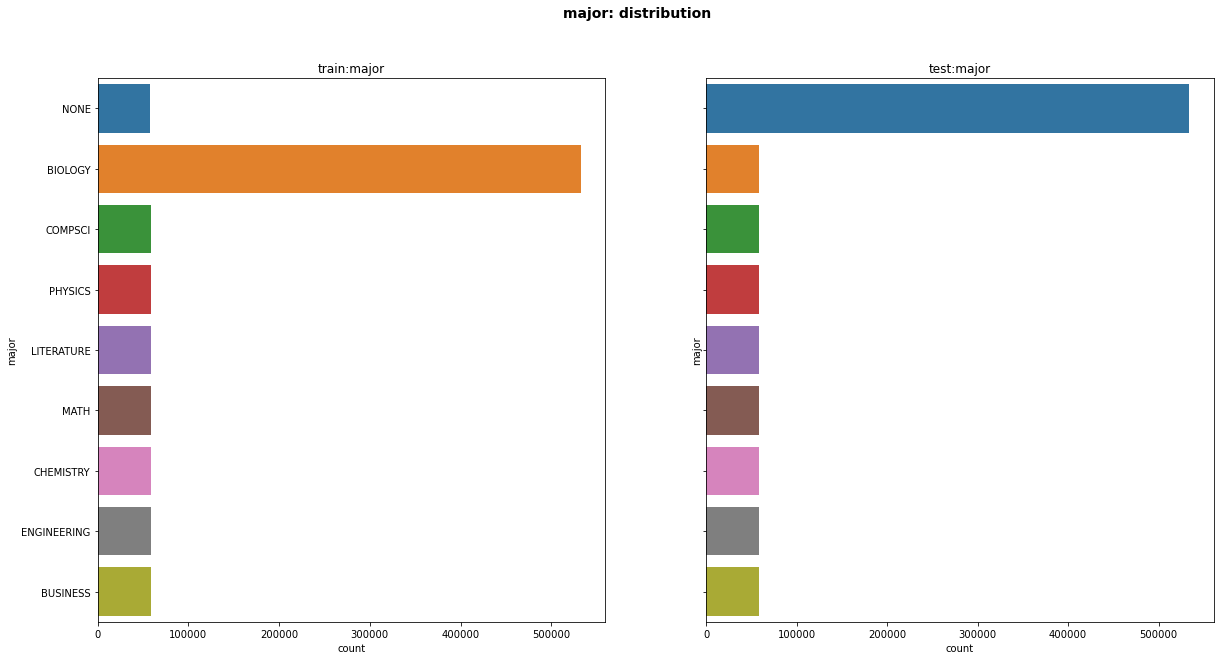

In [14]:
hr_data.plot_variable("major")

Degree and major are different. Both are biased towards the lower levels of education, with NONE being around ten times more frequent than all other majors and "high school" and "none" being the most frequent values among the *degree* categories.

How are *degree* and *major* correlated?

<AxesSubplot:xlabel='major', ylabel='degree'>

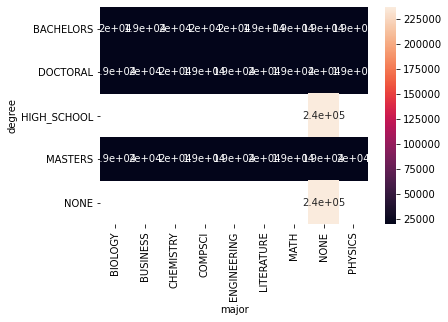

In [15]:
# using len in order to count the co-occurencies.
# then heatmap to dislay them
pivot = hr_data.merged.loc["train"][["degree","major"]].\
        pivot_table(index="degree",columns="major", aggfunc=len)
sb.heatmap(pivot, annot=True)

As expected, all employees with no degree or just high-school education will have "none" as major, but the reverse is not true: "none" seems to be just as likely as any other major value for all the higher education levels.

Let's now have a look at the salary. Hopefully, it is not uniformly distributed as many of the features.

/home/liapunov/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=nan, pvalue=nan)


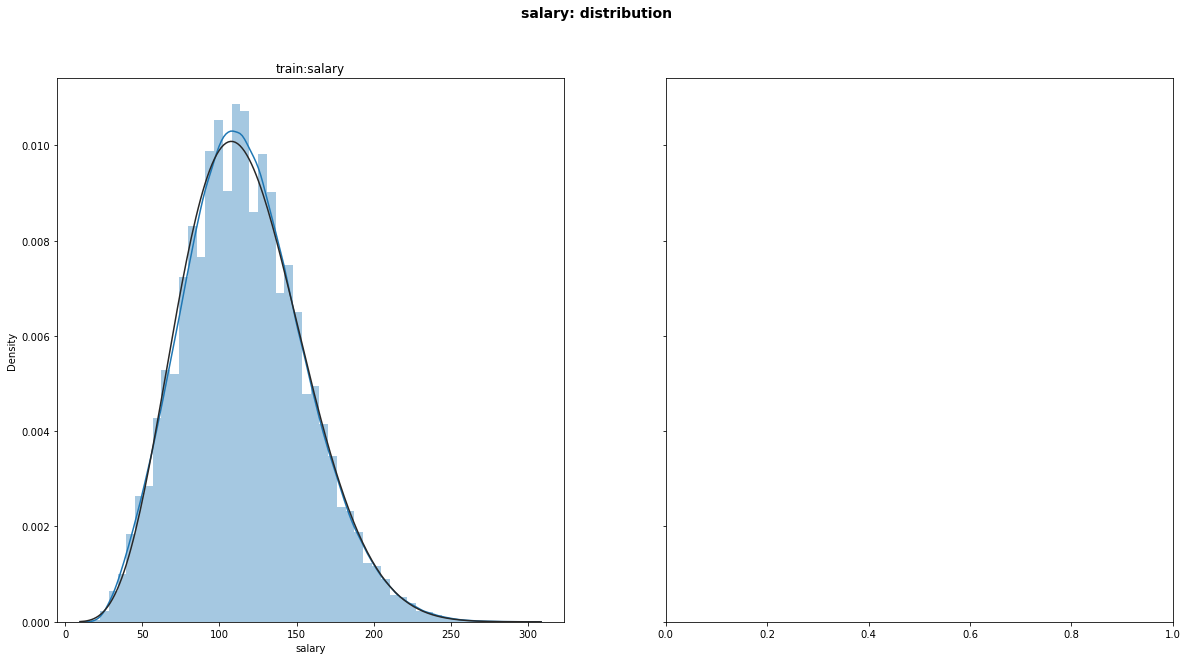

In [16]:
#How are salary distributed in general? Let's fit the series with a Beta distribution
hr_data.plot_variable("salary", fit=beta)
#check for normality
print(normaltest(hr_data.merged.loc["train"]["salary"]))

As we can see, salaries seems to be distributed with a central distribution. Performing a simple normality test makes us exclude the hypothesis that salaries are normally distributed - they possibly follow a beta distribution with a good amount of right skeweness - relatively many very high salaries.

### Relation of the features with the target

We can now move to explore in some detail the possible relations of each of the features with the salary. We hope to extract some useful information in order to formulate an educated hypothesis on the models to consider for the prediction.

Let's start by creating a joint table for features and the salary.

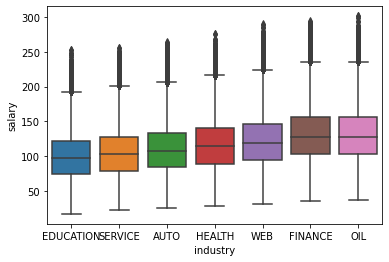

In [17]:
# Distributions of salaries over features can also be synthetically checked with boxplots,
# in which it is easier to show whether a particular value of the features has a significantly
# different mean or variance.


hr_data.plot_vs_target("industry")

While the salary distributions per industry are not *extremely* different, there is some interesting variation. We can note that *Service* and *Education* command lower salaries than all other industries, while *Finance* and *Oil* have indeed a higher mean salary.

We could, only for this time, try and see whether such a variation between salaries is a statistically meaningful one. A good, nonparametric, overall test for the analysis of the variance is the Kruskall-Wallis test.

In [18]:
#split the salary columns into different series by industry
salary_industry_arr = []
for ind in hr_data.merged["industry"].dropna().unique():
    salary_industry_arr.append(hr_data.merged.loc["train"]\
                               [hr_data.merged.loc["train"]["industry"]==ind]["salary"].values)

# Kruskal/Wallis nonparametric omnibus test, just to check whether
# the differences seen above are significant
kruskal(*salary_industry_arr)

KruskalResult(statistic=83284.30288773228, pvalue=0.0)

The resulting statistic is quite high, with a almost null p value. Of course, this does not tell us much other than there is a significant overall variation (whithout identifying *which features* are significantly different) - but at least it tells us we are not looking at an irrelevant difference. We will assume that similar differences between variables will be significant from now on, without any further *post-hoc* analysis.

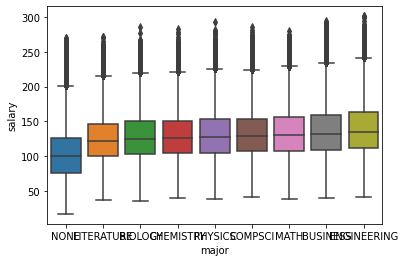

In [19]:
hr_data.plot_vs_target("major")

Here, not having a major seems to be significantly and negatively affetting the salary. Of course, we expect that the result is strongly linked to the general education level. 

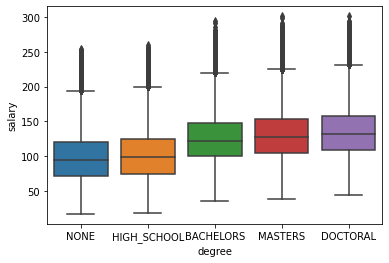

In [20]:
hr_data.plot_vs_target("degree")

As expected, having a *high_school* or a *none* level of education is linked to significantly lower salaries.

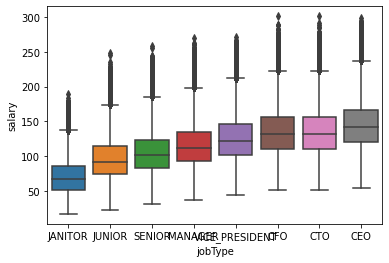

In [21]:
hr_data.plot_vs_target("jobType")

Of course, salaries are expected to be tied to job titles. In the box plot roles like *janitor* and *junior* clearly lie under the 100k dollar stickyard, while *CEO* is slightly under 150.

We could now turn to examining the relationships between the continuous variables. As we noticed before, *milesFromMetropolis* and *yearsExperience* do not have an interesting distribution by themselves. In order to extract some more information, we will also control the graphs by a categorical variable, *jobType*:

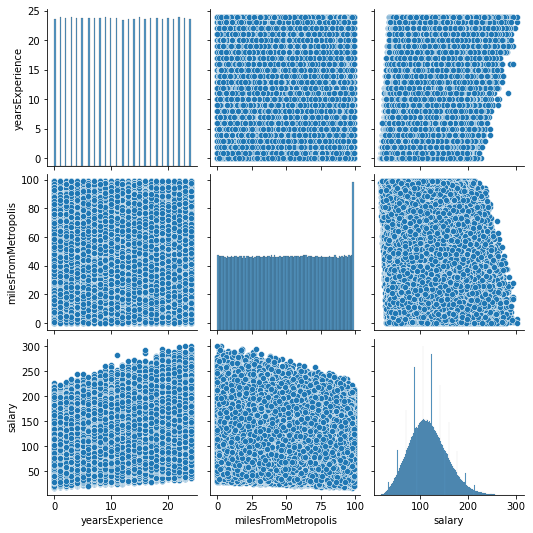

In [22]:
# We could try to extract more information from pair plots,
# for example by checking whether there are any relations between
# continuous variables and controlling by degree or industry
sb.pairplot(hr_data.merged.loc["train"].dropna(),\
            vars=hr_data.numericals,\
            kind="scatter")

The data seem quite noisy and it would be difficult to identify an accurate relation. We can identify two "cap" trends, which we could intepret this way: the longer the experience, the higher the maximum salary; and the higher the salary, the lower the maximum distance.

There is absolutely no interaction between experience and distance from the city.

Now, let's turn our eye to the misterious companyId variable. To analyze this variable better, we will
- create a pivot table of companyId with other categorical variables (mean based)
- check whether there are significant interactions through a heatmap

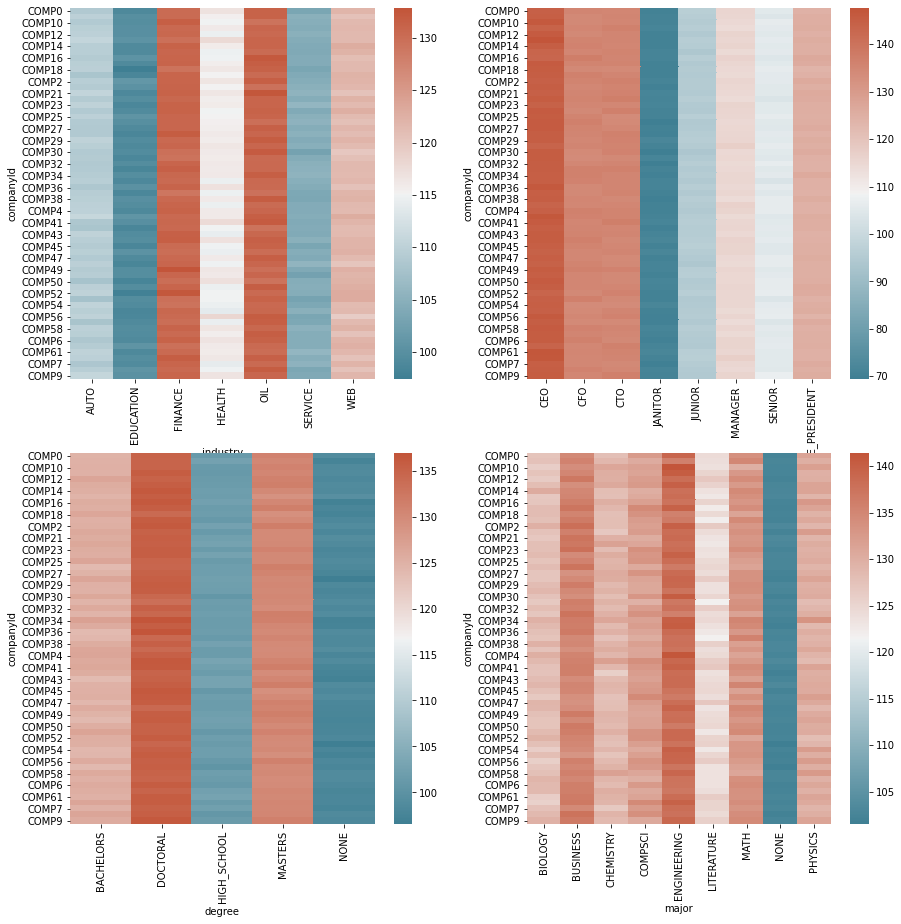

In [23]:
# create a heatmap based on pivot tables with mean aggregate
def hmap_pivot_mean(data, x, y, target, ax):
    sb.heatmap(data.pivot_table(index=x,columns=y,values=target, aggfunc=np.mean),\
               cmap=sb.diverging_palette(220, 20, as_cmap=True), ax=ax)

fig_comp,ax_comp = plt.subplots(figsize=(15,15), nrows=2,ncols=2)


hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="industry",target="salary", ax=ax_comp[0][0])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="jobType",target="salary", ax=ax_comp[0][1])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="degree",target="salary", ax=ax_comp[1][0])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="major",target="salary", ax=ax_comp[1][1])


Uhm. It seems that this variable is almost completely noise. We have some doubt it might bring some kind of information together with the major. Might it be that some companies are privileging some kind of major over others? Let's give companyId some hope in that direction and let's refrain from deleting it right now.

## Looking for a good predicting model

### Defining a valid reference point for performance evaluation

We need to establish a baseline in order to understand what value a ML model is adding to the processes of a typical company that might use salary data like these.

In this case, we can assume that an hypothetical company owning the current dataset has already created **relatively simple tables** with the average salary for a certain number of clusters of jobs.

How to choose which segments are relevant to build such a table?
Again, we are assuming that the table size must be a *good compromise between accuracy and usability* - we do not want to manage thousands of different segments.

Based on the box plots above, we see that a good part of the variance seems to be explained by the differences in **Job Title** and in **Industry**. Of course, having a major in STEM versus not having a degree also seems to have statistically significant effects, but we do not want to make the reference table unwieldy for the users.

Let's try then to create a reference table of salaries by industry and job title. This should result in a 7x8 table, simple enough for manual consultation.

In [24]:
# We create a toy model based on what we have seen before.
# We will ignore the slight cap effect of experience and distance from the city for now.
# We will use a 8x7 table created by crossing the major with the industry

# We will use the Mean Squared Error to assess the performance of the model,
# through a 5-fold crossvalidation
class TableModel:

    def __init__(self, data, ref_variables):
        self.train = data.get_train(dropna=True)
        self.variables = ref_variables
        self.target = data.target_col
        
    def cv_train(self, folds):

        n_fold_cv = KFold(n_splits=folds, shuffle=True)

        MSE = 0

        # TRAINING/VALIDATION FOLD
        for i in range(folds):
            split = next(n_fold_cv.split(self.train))
            this_train_set = self.train.iloc[split[0]][self.variables + [self.target]]
            this_valid_set = self.train.iloc[split[1]][self.variables + [self.target]]

            # "TRAINING"
            # create the table-model (n major values x m industry values)
            ref_table = this_train_set.groupby(self.variables)[self.target].mean().reset_index()

            # "VALIDATION"
            # split the validation set in features and target
            # then estimate the salary based on the table above
            valid_target = this_valid_set.pop(self.target).values
            est_target = this_valid_set[self.variables].merge(ref_table, how="left")[self.target].values

            MSE += np.mean((valid_target - est_target)**2)

        # Calculate the average MSE of the 5-fold CV
        baseline_MSE = MSE/folds
        return (ref_table, baseline_MSE)

In [25]:
ind_job_table = TableModel(hr_data, ["jobType","industry"])
table_res = ind_job_table.cv_train(5)
print(table_res[1])

833.5461277537142


As we can see, using a relatively simple reference table, which does not even use all of the features, we are able to obtain a Mean Square Error of slightly above 800. Roughly speaking, we should expect to guess a salary within a range of +/- 29k dollars, which is the square root of the error.

Is it good enough? A gross metrics to judge the goodness of this error could be the ratio of the root mean squared error to the standard deviation of salary for the general population - that is, roughly, the improvement over picking the average salary of the whole dataset:

In [26]:
np.sqrt(table_res[1]) / hr_data.get_train()["salary"].std()

0.7456950976643699

The RMSE is 74% of the standard deviation. This is of course an improvement, but definitely not a major one. Can we do better, say at least below 50%? This would correspond to a MSE of around 370.

In [27]:
(0.5 * hr_data.get_train()["salary"].std()) ** 2

374.75468514606985

The table-based model above (with only about 60 parameters) performs decently with a validation MSE just above 800, but clearly it does not make use of several features in the model, most notably:
1. linear cap effects of experience (ascending) and distance from the city (descending)
2. peculiarities of each company
3. job seniority

In fact, it does not take into account any feature interaction other than the couple jobType/industry.

With 1 million rows and virtually no unbalances in the value distributions for each feature, the dataset is robust enough to be attacked with several low bias learning algorithms, including neural networks, with sufficient regularization.
Other choices might include:
 - Linear regression models, specifically regularized models such as Lasso or Ridge. This has the advantage of having minimal training times, but we expect a higher bias
 - Decision (regression) trees regressors, in particular in ensemble (e.g. Random Forests). This class of models is known to perform fairly well on a wide range of problems

It might be useful to consider the nature of the dataset, which has mixed categorical/numerical features.
Using neural networks, kNNs or random forests through sklearn requires transforming the categorical variables into dummy variable or one-hot encoded factors.
If you want to preserve categories as they are and use RF, you might avail of H20, which boasts one of the fastest RF algorithms and can handle categories natively. (http://docs.h2o.ai)

We will keep on with sklearn and proceed to engineer our dataset this time.

### Engineering features

Considering the three models we are going to test, and the number of training examples, we could operate two simple transformations:

1. **Add or transform features:** we are going to transform some of the existing categorical features into ordinal ones. Also, we are introducing new features as aggregate statistics from existing ones. 
2.  **"Dummify" the categorical features**: transform each categorical variable into binary features. Since we are going to use linear models such as Lasso and Ridge, to minimize the risk of multicollinearity it is better to use a dummy strategy, that is, reduce the number of features into n-1 categories, so that the nth is not construed as the linear combination of the others (regularization should take care of this problem already, to some extent)
3.  **Normalize the features**: with the exception of the dummies, all the continuous features. It is not necessary to normalize the target value (why? See [here](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re)) 

After applying these transformations, we can finally detach the salary into the target, to be fed into our models.

An important action we should take before experimenting with our models is to **prepare a small validation set**. Even if we are going to use cross-validation for Random Forests and Lasso/Ridge, it is safer to reserve  small portion of the data to have a final validation with examples that have not been used for parameter tuning.
Of course, we *are not going to use the validation score to adjust parameters*. It will be the final, official score of each model.

#### a. transform jobType and degree into an ordinal variable
As you can see from the dictionary below, we will merge two of the levels, CFO and CTO, as their mean salary is basically the same and we do not have evidence that a CXO position other than CEO should have a priority over the others.
All other jobType levels seem to follow a clear order.

In [28]:
job_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5,\
           "CTO":5, "CEO": 6}
hr_data.dict_replace("jobType",job_dict)

hr_data.merged.head()

jobId companyId  jobType       degree      major industry  \
train 0  JOB1362684407687    COMP37      5.0      MASTERS       MATH   HEALTH   
      1  JOB1362684407688    COMP19      6.0  HIGH_SCHOOL       NONE      WEB   
      2  JOB1362684407689    COMP52      4.0     DOCTORAL    PHYSICS   HEALTH   
      3  JOB1362684407690    COMP38      3.0     DOCTORAL  CHEMISTRY     AUTO   
      4  JOB1362684407691     COMP7      4.0    BACHELORS    PHYSICS  FINANCE   

         yearsExperience  milesFromMetropolis  salary  
train 0             10.0                 83.0   130.0  
      1              3.0                 73.0   101.0  
      2             10.0                 38.0   137.0  
      3              8.0                 17.0   142.0  
      4              8.0                 16.0   163.0

There seems to be a clear and clean order between the levels of "degree", therefore we will transform this feature into an ordinal one as well.

In [29]:
# Transform the degree variable into an ordinal number

degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}

hr_data.dict_replace("degree",degree_dict)
hr_data.merged.head()

jobId companyId  jobType  degree      major industry  \
train 0  JOB1362684407687    COMP37      5.0     3.0       MATH   HEALTH   
      1  JOB1362684407688    COMP19      6.0     1.0       NONE      WEB   
      2  JOB1362684407689    COMP52      4.0     4.0    PHYSICS   HEALTH   
      3  JOB1362684407690    COMP38      3.0     4.0  CHEMISTRY     AUTO   
      4  JOB1362684407691     COMP7      4.0     2.0    PHYSICS  FINANCE   

         yearsExperience  milesFromMetropolis  salary  
train 0             10.0                 83.0   130.0  
      1              3.0                 73.0   101.0  
      2             10.0                 38.0   137.0  
      3              8.0                 17.0   142.0  
      4              8.0                 16.0   163.0

#### b. Create a group-mean variable

In [30]:
hr_data.create_grouped_stats(["jobType","major","degree","industry"])
hr_data.merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,groupMean,groupMedian,groupVar
level_0,,,,,,,,,,,,
train,JOB1362684407687,COMP37,5.0,3.0,MATH,HEALTH,10.0,83.0,130.0,145.247268,142.5,905.171333
train,JOB1362684407688,COMP19,6.0,1.0,NONE,WEB,3.0,73.0,101.0,140.051566,138.0,871.482642
train,JOB1362684407689,COMP52,4.0,4.0,PHYSICS,HEALTH,10.0,38.0,137.0,133.640097,132.0,733.107444
train,JOB1362684407690,COMP38,3.0,4.0,CHEMISTRY,AUTO,8.0,17.0,142.0,118.915865,117.0,645.653145
train,JOB1362684407691,COMP7,4.0,2.0,PHYSICS,FINANCE,8.0,16.0,163.0,142.290323,140.0,927.704060


#### c. Clustering companyId
We have already seen that companyId seems to be quite uninformative, but there might be some chance that combining the company information with the major information might actually grant us some extra info.
We will cluster the combinations of (major, companyId) into 5 clusters according to their salary level.
Then, we will get rid of the original companyId variable.

In [31]:
# create a table with the average salary by
comp_pivot = hr_data.get_train().dropna().pivot_table(index=["companyId"],columns=["major"],\
                                                      values="salary")

kmeans_trans = KMeans(n_clusters=5, n_jobs=-1)

In [32]:
kmeaned_pivot = kmeans_trans.fit(comp_pivot.values)
clusters_dict = dict(zip(comp_pivot.index,kmeaned_pivot.labels_))
hr_data.merged["companyId"].replace(clusters_dict,inplace=True)
hr_data.merged.head()

/home/liapunov/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,groupMean,groupMedian,groupVar
level_0,,,,,,,,,,,,
train,JOB1362684407687,0.0,5.0,3.0,MATH,HEALTH,10.0,83.0,130.0,145.247268,142.5,905.171333
train,JOB1362684407688,0.0,6.0,1.0,NONE,WEB,3.0,73.0,101.0,140.051566,138.0,871.482642
train,JOB1362684407689,1.0,4.0,4.0,PHYSICS,HEALTH,10.0,38.0,137.0,133.640097,132.0,733.107444
train,JOB1362684407690,1.0,3.0,4.0,CHEMISTRY,AUTO,8.0,17.0,142.0,118.915865,117.0,645.653145
train,JOB1362684407691,4.0,4.0,2.0,PHYSICS,FINANCE,8.0,16.0,163.0,142.290323,140.0,927.704060


#### d. One-hot encoding the categorical variables

In [33]:
# One-hot encoding pure categorical data

    
hr_data.to_one_hot(["companyId","jobType","major","industry"])
hr_data.merged.head()

,jobId,degree,yearsExperience,milesFromMetropolis,salary,groupMean,groupMedian,groupVar,companyId_0.0,companyId_1.0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
level_0,,,,,,,,,,,,,,,,,,,,,
train,JOB1362684407687,3.0,10.0,83.0,130.0,145.247268,142.5,905.171333,1,0,...,1,0,0,0,0,0,1,0,0,0
train,JOB1362684407688,1.0,3.0,73.0,101.0,140.051566,138.0,871.482642,1,0,...,0,1,0,0,0,0,0,0,0,1
train,JOB1362684407689,4.0,10.0,38.0,137.0,133.640097,132.0,733.107444,0,1,...,0,0,1,0,0,0,1,0,0,0
train,JOB1362684407690,4.0,8.0,17.0,142.0,118.915865,117.0,645.653145,0,1,...,0,0,0,1,0,0,0,0,0,0
train,JOB1362684407691,2.0,8.0,16.0,163.0,142.290323,140.0,927.704060,0,0,...,0,0,1,0,0,1,0,0,0,0


In [34]:
# Normalizing the numerical variables;

hr_data.scale(["yearsExperience","milesFromMetropolis","groupMean","groupMedian", "groupVar",\
               "degree"], "standard")
hr_data.merged.head()

,jobId,degree,yearsExperience,milesFromMetropolis,salary,groupMean,groupMedian,groupVar,companyId_0.0,companyId_1.0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
level_0,,,,,,,,,,,,,,,,,,,,,
train,JOB1362684407687,0.832998,-0.276905,1.158857,130.0,1.041985,1.039177,1.159533,1,0,...,1,0,0,0,0,0,1,0,0,0
train,JOB1362684407688,-0.571489,-1.247404,0.812642,101.0,0.856587,0.880673,0.954944,1,0,...,0,1,0,0,0,0,0,0,0,1
train,JOB1362684407689,1.535241,-0.276905,-0.399114,137.0,0.627807,0.669333,0.114602,0,1,...,0,0,1,0,0,0,1,0,0,0
train,JOB1362684407690,1.535241,-0.554190,-1.126168,142.0,0.102405,0.140984,-0.416501,0,1,...,0,0,0,1,0,0,0,0,0,0
train,JOB1362684407691,0.130754,-0.554190,-1.160789,163.0,0.936472,0.951119,1.296373,0,0,...,0,0,1,0,0,1,0,0,0,0


Now that we have transformed all variables into digits, it is much more easy to verify the correlations with a heatmap.

<AxesSubplot:>

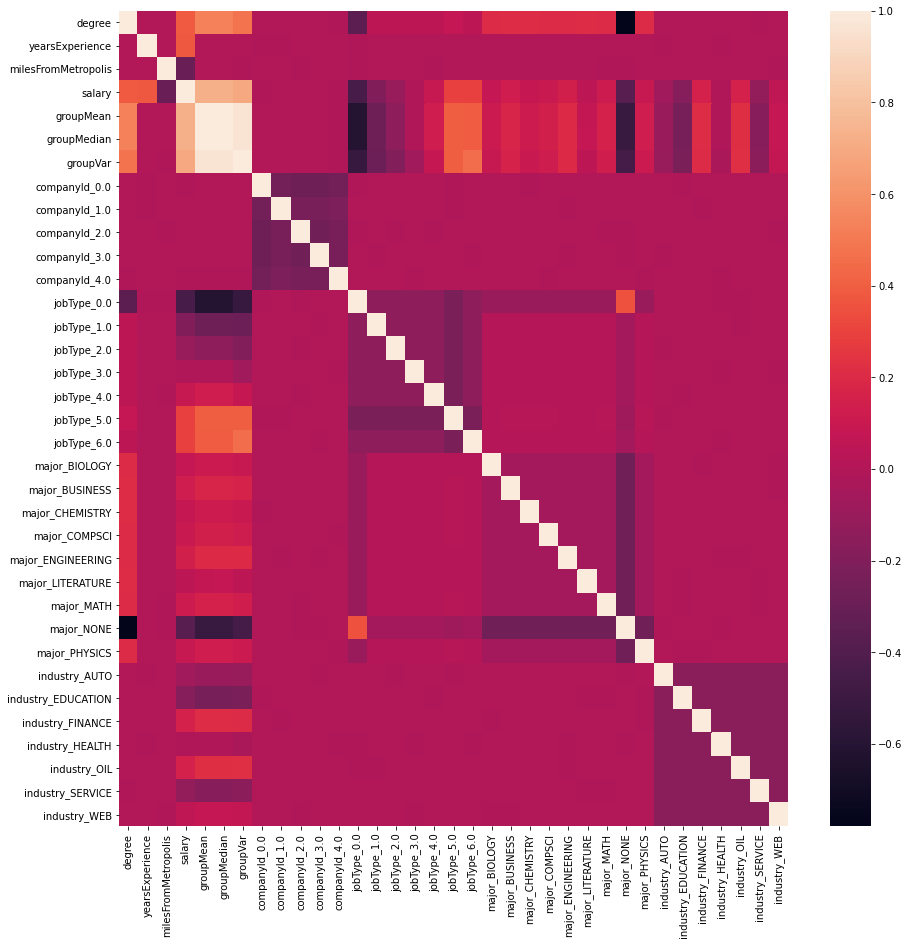

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(hr_data.merged.loc["train"].corr())

Oops. It seems that even reducing the company variables there is no noticeable correlation with the salary. We will just drop them.

In [36]:
# Now we can detach the target (salary) from the features
hr_data.merged = hr_data.merged.drop(columns=["jobId"]+["companyId_{}.0".\
                                         format(i) for i in range(5)])

We have completed the cleaning and the transformation of the data. Now we can split them into train and validation.

In [37]:
feat, salaries = hr_data.split_feature_target()

In [38]:
feat.describe()

,degree,yearsExperience,milesFromMetropolis,groupMean,groupMedian,groupVar,jobType_0.0,jobType_1.0,jobType_2.0,jobType_3.0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
count,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,...,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000
mean,0.001087,-0.000672,0.000051,0.000585,0.000573,0.000656,0.124972,0.124593,0.125887,0.125121,...,0.057800,0.532356,0.058410,0.142942,0.142820,0.142867,0.142756,0.142771,0.142640,0.143206
std,0.999818,0.999945,0.999793,1.000149,1.000118,0.999914,0.330687,0.330257,0.331722,0.330856,...,0.233366,0.498952,0.234518,0.350014,0.349889,0.349937,0.349824,0.349839,0.349705,0.350283
min,-1.273732,-1.663332,-1.714735,-2.177810,-2.183751,-1.727057,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.571489,-0.831476,-0.849195,-0.726150,-0.739597,-0.829587,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.130754,0.000381,0.016345,0.105143,0.105761,-0.031736,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.832998,0.832237,0.881885,0.702405,0.704556,0.705300,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.535241,1.664093,1.712803,2.788473,2.782729,3.799155,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# Since we are going to perform many cross/validated tests to tune the model,
# it is recommendable to keep a few samples for a final validation

train_feat, val_feat, train_salaries, val_salaries = train_test_split(feat,salaries,\
                                                     test_size=0.1, random_state=31)

### Let's initialize the models

As mentioned above we will initialize and tune three families of models:
1. **Regularized linear models**: they are simple, yet robust methods that can deal with numerous features and generalize better than the standard linear regression. The main parameter to set here is alpha, that is, the coefficient of the regularization component in the loss function.
2. **Gradient Boost Models**: this powerful, relatively simple family of models builds on decision trees and learns an ensemble of weak predictors (regressors) to improve generalization while keeping bias low. One definite advantage of GBM over Random Forests is the efficiency of memory and the overall speed.
With lightGBM, which also supports GPUs and parallelism, we are going to experiment on a couple of parameters: the learning rate of the gradient update, the *maximum depth* of each weak learner/tree, and the number of leaves that the algorithm needs to build. Of course, increasing too much max_depth and n_leaves is going to damage generalization and increase the learning time.
3. **Neural Networks**: we will try applying a somewhat vanilla-variety of this powerful family of models. Neural network work very well with many data rows (provided one has the computing power) and have less problems than other models in keeping bias and variance on check, but the number of parameters that needs to be tuned is high, with several nonlinear interferences between one parameter and the others. We will use **Keras** to build a sequential network and try to keep as many defaults as possible.

First, we build our linear regressors. Lasso and Ridge are regularized versions of the classical linear regression. The difference between the two is that Lasso utilizes a L1 regularization (the penalty factor is directly proportional to the weights) while Ridge features a L2 regularization (the penalty and the weights are quadratically related). The practical difference is that Lass tends to create a model with less non-zero features overall. 
For more information: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

In [40]:
# Using sklearn Linear_model library to instantiate Lasso and Ridge regressor
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
# These values of alpha worked reasonably well
Lasso_reg = Lasso(alpha=0.1)
Ridge_reg = Ridge(alpha=0.1)

Next, we build our LGBM model.
Of course, we are using a GBM *regressor*, which means that the model will spout the level of the output based on the votes of the ensemble learners/trees (which themselves are spouting the mean of the values included in the specific decision segment for each tree).

Although lightgbm offers different parameters to tune, we will make do with the above-mentioned three: learning_rate,  max_depth and n_leaves.

In [41]:
# Using the lightgbm library
# https://lightgbm.readthedocs.io

# These are the parameters that worked better. 
my_gbm = lgbm.LGBMRegressor(learning_rate=0.1, reg_lambda=0.01,\
                            reg_alpha=0.1, n_jobs = -1)

Finally, we implement a simple Neural Networks through Tensorflow and Keras. As the model seems relatively low-dimensional and static, we will build a sequential network with a limited number of layers. Of course the depth of the network as well as the number of neurons per layer will be subject to tuning and validation.

Other than that, we might look into the optimizer to see whether tweaking the learning rate will have some positive effect. We will use Adam as it is relatively stable and most of its parameters can be left alone. Note that we will avail of dropout and batch normalization to respectively regularize the network and improve the accuracy of the final layers.

In [55]:
# Creating a Keras sequential model with dropout
# As this is a regression, the last layer will have a linear activation

my_NN = Sequential([
    Dense(60, activation="relu", input_shape=(29,)),
    Dense(200, activation="relu"),
    Dense(29, activation="relu"),
    Dense(200, activation="relu"),
    Dense(29, activation="relu"),
    Dense(200, activation="relu"),
    Dense(29, activation="relu"),
    Dense(60, activation="relu"),
    Dense(1, activation="linear"),
    ])

### Tuning and cross-validation of the models

In [43]:
# We are using mean_squared_error as error metric

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [44]:
# L1 regularization regression with 5-fold CV
Lasso_scores = cross_validate(Lasso_reg, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


In [45]:
# L2 regularization regression with 5-fold CV
Ridge_scores = cross_validate(Ridge_reg, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=4, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [46]:
# Gradient boost with lightgbm with 5-fold CV
gbm_scores = cross_validate(my_gbm, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .......... , score=(train=-352.163, test=-355.666), total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV] .......... , score=(train=-352.199, test=-355.064), total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s


[CV] .......... , score=(train=-352.724, test=-353.174), total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.4s remaining:    0.0s


[CV] .......... , score=(train=-352.506, test=-354.142), total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.7s remaining:    0.0s


[CV] .......... , score=(train=-351.649, test=-356.599), total=   4.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.2s finished


In [56]:
#from keras.optimizers import Adam
#my_opt = Adam(lr=0.001)
my_NN.compile(optimizer="adam", loss="mse")
my_NN.fit(train_feat, train_salaries, validation_split=0.1, epochs=30, batch_size=512)

Epoch 1/30
1583/1583 [==============================] - 10s 6ms/step - loss: 637.3432 - val_loss: 370.7441
Epoch 2/30
1583/1583 [==============================] - 10s 6ms/step - loss: 360.2462 - val_loss: 392.9441
Epoch 3/30
1583/1583 [==============================] - 10s 6ms/step - loss: 359.6086 - val_loss: 356.3423
Epoch 4/30
1583/1583 [==============================] - 10s 6ms/step - loss: 359.0204 - val_loss: 384.6291
Epoch 5/30
1583/1583 [==============================] - 9s 6ms/step - loss: 358.4789 - val_loss: 417.7795
Epoch 6/30
1583/1583 [==============================] - 10s 6ms/step - loss: 358.3983 - val_loss: 420.7088
Epoch 7/30
1583/1583 [==============================] - 10s 6ms/step - loss: 358.0944 - val_loss: 368.7419
Epoch 8/30
1583/1583 [==============================] - 9s 6ms/step - loss: 357.7973 - val_loss: 356.3011
Epoch 9/30
1583/1583 [==============================] - 10s 6ms/step - loss: 358.0081 - val_loss: 363.5015
Epoch 10/30
1583/1583 [================

Let's have a look at the cross-validation score for each of the methods used above.

In [49]:
Lasso_train_score = Lasso_scores["test_score"].mean()
Ridge_train_score = Ridge_scores["test_score"].mean()
GBM_train_score = gbm_scores["test_score"].mean()

print(Lasso_train_score)
print(Ridge_train_score)
print(GBM_train_score)

-370.960871139437
-370.9332440565467
-354.9289829752988


Among the cross-validated methods, GBM clearly has the upper hand, even if all three algorithms have gone under the treshold of 374 that we set earlier.

Let's have a look at what features has GBM given more weight in training its tree:

<AxesSubplot:>

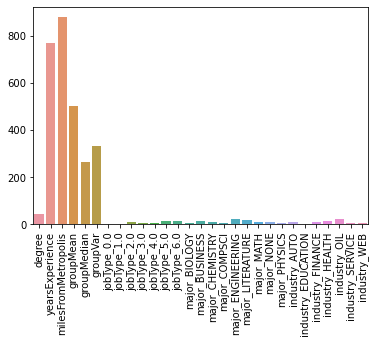

In [50]:
plt.xticks(rotation=90)

sb.barplot(x=train_feat.columns, y=gbm_scores["estimator"][0].feature_importances_)

It seems that milesFromMetropolis, yearsExperience and the group statistics have been given the highest importance in building the boosted tree.

### Selecting the best model

In [57]:
print("Lasso Validation score: {}".\
      format(mean_squared_error(val_salaries,Lasso_scores["estimator"][0].predict(val_feat))))
print("Ridge Validation score: {}".\
      format(mean_squared_error(val_salaries,Ridge_scores["estimator"][0].predict(val_feat))))
print("GBM validation score: {}".\
     format(mean_squared_error(val_salaries,gbm_scores["estimator"][3].predict(val_feat))))
print("NN validation score: {}".\
     format(my_NN.evaluate(val_feat,val_salaries)))

Lasso Validation score: 371.92932795264744
Ridge Validation score: 371.89115356762136
GBM validation score: 356.0676842358832
3125/3125 [==============================] - 4s 1ms/step - loss: 356.6963
NN validation score: 356.6963195800781


The GBM validation score is on par with the Neural Network performance, despite the significantly faster training time. We are going to use GBM for the production data.

### Putting the best model to use
Having ascertained that the GBM model achieves an interesting performance at a fraction of the resources employes by a TF NN model, we can fit it with the whole training set and explore it further, in order to extract more information about what it has learned and the predictions it makes.

While not being entirely transparent, each tree-based model can report part of its structure by revealing the _importance_ of each feature, measured as the average weight each feature gives to the output. This feature is a clear advantage compared to neural networks, although sampling methods can be used to infer feature importance of some of the inputs.

More information about features importance in gradient boosted trees can be found here:
https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting

In [59]:
# training GBM on the whole training set
whole_gbm = my_gbm.fit(feat,salaries)
test_feat = hr_data.get_test()
predictions = whole_gbm.predict(test_feat)

<AxesSubplot:>

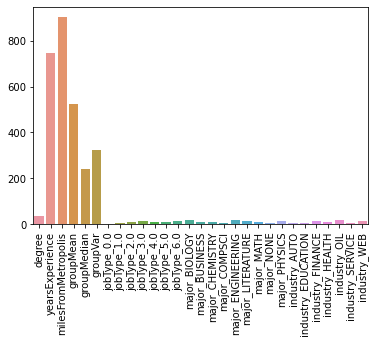

In [60]:
plt.xticks(rotation=90)

sb.barplot(x=train_feat.columns, y=whole_gbm.feature_importances_)

It seems clear that five features dominate the model:
- The distance from the city center
- The years of experience of the employee
- The aggregate mean, variance and median of the salaries for each group based on the quartet "jobType", "major", "degree", "industry". These aggregate variables basically absorb almost all the relevant information from the four features above.

Let's now attach the predictions to the original features so that we can sample a few predictions and do a visual sanity check:

In [61]:
original_test = pd.read_csv(file_base + "test_features.csv")
original_test["predictions"] = predictions
original_test.sample(20)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,predictions
693195,JOB1362686100882,COMP19,CEO,HIGH_SCHOOL,NONE,AUTO,22,99,120.218386
698379,JOB1362686106066,COMP59,CEO,NONE,NONE,HEALTH,0,47,105.441797
50133,JOB1362685457820,COMP39,JANITOR,NONE,NONE,FINANCE,9,82,69.038002
796210,JOB1362686203897,COMP48,MANAGER,MASTERS,LITERATURE,EDUCATION,14,47,112.272294
460393,JOB1362685868080,COMP9,CFO,NONE,NONE,EDUCATION,14,85,93.208668
150372,JOB1362685558059,COMP15,VICE_PRESIDENT,HIGH_SCHOOL,NONE,EDUCATION,7,33,96.231365
618809,JOB1362686026496,COMP55,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,20,62,158.073423
647425,JOB1362686055112,COMP7,JUNIOR,DOCTORAL,LITERATURE,SERVICE,24,26,129.584757
763110,JOB1362686170797,COMP60,CEO,BACHELORS,ENGINEERING,SERVICE,13,80,126.693343
433217,JOB1362685840904,COMP14,VICE_PRESIDENT,BACHELORS,LITERATURE,SERVICE,14,52,112.964361


Apparently, the predictions make sense. While a Janitorial role with no higher education in finance has a predicted salary of 69,000 USD, a Vice-president position for a professional with doctoral degree in the Oil industry has a predicted salary of 158,000 USD.
Let's see the distribution of the predicted salaries and see if it kept the skewness towards higher salaries.

/home/liapunov/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='Density'>

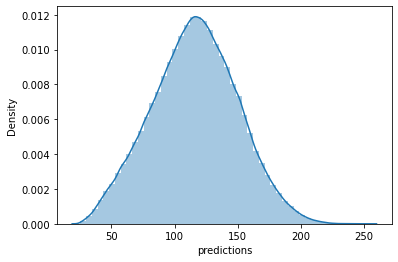

In [64]:
sb.distplot(original_test.predictions)

The distribution has conserved some skewness, although there are less extreme values compared to the original distribution. This might mean that the model has lost some information on the tail (relatively few examples with a chance of underfitting), or that the distribution of the features for the test differ from the original training set.

### Saving the predictions

In [65]:
original_test.to_csv(file_base+"results.csv")

# Conclusion
We have created a class that can simplify the workflow of cleaning, augmenting and fitting the data. We have used salary data, but the framework can easily work with other tabular data presenting categorical and continuous features.

The SupervisedDataFrame class can be used to automatize simple model learning flows like the above, either with pipeline frameworks (sklearn pipeline, Airflow) or directly. As an example, here is a simple function that takes the training and test files as inputs, and returns the cleaned and transformed dataframes ready to be fitted and predicted.

In [0]:
feat, salaries, test_feat = short_track("train_features.csv","test_features.csv","train_salaries.csv")

Creating new Supervised Dataframe instance...
created dataframes with implied target column "salary"
Implied categorical variables: ['companyId', 'degree', 'industry', 'jobId', 'jobType', 'major']
Implied numerical variables: ['milesFromMetropolis', 'salary', 'yearsExperience']
Implied datetime variables: []
information about the train DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
companyId              1000000 non-null object
degree                 1000000 non-null object
industry               1000000 non-null object
jobId                  1000000 non-null object
jobType                1000000 non-null object
major                  1000000 non-null object
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null float64
yearsExperience        1000000 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 76.3+ MB
information about the test DataFrame:
<class 'pandas.co